This notebook shows a quickstart overview of how to call SkyLine and run the basic functions to obtain the mock observations, as well as obtaining some of the measurements of the summary statistics of interest.

For any doubt or further question, check the readme, the input_parameter_description file, or contact the developers

In [1]:
#Add the package to your python path
import sys
#sys.path.append('/home/jlbernal/SkyLine/') #your path here if not included by default

#Import standard packages for computations, unit and plotting
import numpy as np
import astropy.units as u
import astropy.constants as cu
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RegularGridInterpolator
import matplotlib.gridspec as gridspec
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

#Our matplotlib stlye
palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

#colors
dark_blue='#324356'
turquoise='#54858a'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [dark_blue,turquoise,yellow,yellow_orange,orange])

Import SkyLine and define the path to the directory where you store the lightcone halo catalogs

In [2]:
from SkyLine import make_lightcone, make_survey, make_measurements

LC_path='/home/jlbernal/LightCone_S82_UM/'

Define your input parameters (check `input_parameter_description.md` for details about them and default values!). Some of them are mandatory (no default value). Here we only include some, and our fiducials in the first paper for the models of each line, with some short description commented next to them. The details for each model can be found in `source/line_models.py`, and it's easy to add your own there following the style 

In [3]:
def LC_params(line):
    '''
    This function is a proxy to return a dictionary with the input parameters to call SkyLine. 
    
    This function it's designed to get the same noise, resolution and redshift coverage for all lines, 
    but serves as an example for any application
    '''
    h=0.678 #Reduced Hubble constant from the lightcone. This is default, used here for h-based units
    
    #survey and experimental parameters
    zmin = 2.5;zmax = 3.5 #minimum and maximum redshift of the survey (to load lightcone slices)
    zmid=(zmax+zmin)/2 #mid redshift
    R=700 # Spectral Resolution
    ang_lim=2*u.deg #RA and DEC (total) width of the survey
    
    #line-dependent parameters
    if line=='CO':
        nu_CO=115.271*u.GHz #rest-frame frequency
        dnu=nu_CO/(1+zmid)/R #channel witdh for this case
        nuObs_max, nuObs_min = nu_CO/(1+zmin), nu_CO/(1+zmax) #The edges of the bandwith of the experiment for this case
        #values for which line to include and its model
        lines = dict(CO_J10=True) 
        target_line = 'CO_J10'
        line_models = dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                     model_pars={'alpha':0.674,'beta':4.898,'alpha_std':0,'beta_std':0,'sigma_L':0.2})) #you can add more lines to the dictionary. Structure is "dict(<line_id1>=dict(model_name=<your model>,model_pars = {<dict with the params>}), <line id2>=...)"; you only need to specify the lines included
        #whether measure intensity or temperature
        do_intensity = False
        Tsys=0*u.uK #system temperature (0 for noiseless exp). Careful with units, depends on the do_intensity
        
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        dnu=nu_CII/(1+zmid)/R #channel witdh for this case
        nuObs_max, nuObs_min = nu_CII/(1+zmin), nu_CII/(1+zmax) #The edges of the bandwith of the experiment for this case
        #values for which line to include and its model
        lines = dict(CII=True) 
        target_line = 'CII'
        line_models = dict(CII=dict(model_name='CII_Lagache18',
                     model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})) #you can add more lines to the dictionary. Structure is "dict(<line_id1>=dict(model_name=<your model>,model_pars = {<dict with the params>}), <line id2>=...)"; you only need to specify the lines included
        #whether measure intensity or temperature
        do_intensity = True
        Tsys=0*u.Jy/u.sr #system temperature (0 for noiseless exp). Careful with units, depends on the do_intensity
    
    elif line=='Lyalpha':
        nu_Lya=2465398.5*u.GHz
        dnu=nu_Lya/(1+zmid)/R
        nuObs_max, nuObs_min = nu_Lya/(1+zmin), nu_Lya/(1+zmax) #The edges of the bandwith of the experiment for this case
        #values for which line to include and its model
        lines = dict(Lyalpha=True) 
        target_line = 'Lyalpha'
        line_models = dict(Lyalpha=dict(model_name='Lyalpha_Chung19',
                     model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,'psi':0.875,'z0':3.125,'f0':0.18,'SFR0':0.5,'sigma_L':0.3})) #you can add more lines to the dictionary. Structure is "dict(<line_id1>=dict(model_name=<your model>,model_pars = {<dict with the params>}), <line id2>=...)"; you only need to specify the lines included
        #whether measure intensity or temperature
        do_intensity = True
        Tsys=0*u.Jy/u.sr #system temperature (0 for noiseless exp). Careful with units, depends on the do_intensity
    elif line=='HI': #21cm!
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        nuObs_max, nuObs_min = nu_HI/(1+zmin), nu_HI/(1+zmax) #The edges of the bandwith of the experiment for this case
        #values for which line to include and its model
        lines = dict(HI=True) 
        target_line = 'HI'
        line_models = dict(HI=dict(model_name='HI_VN18',
                     model_pars={'M0':2.9e9*u.Msun/h, 'Mmin':6.7e10*u.Msun/h,'alpha':0.76,'sigma_MHI':0.2})) #you can add more lines to the dictionary. Structure is "dict(<line_id1>=dict(model_name=<your model>,model_pars = {<dict with the params>}), <line id2>=...)"; you only need to specify the lines included
        #whether measure intensity or temperature
        do_intensity = False
        Tsys=0*u.uK #system temperature (0 for noiseless exp). Careful with units, depends on the do_intensity
        
    
    #Create the dictionary and fill it. 
    params=dict(halo_lightcone_dir=LC_path, #specify the path to the directory with the lightcone slices
                do_external_SFR = False, external_SFR = '', SFR_pars=dict(), #we use UniverseMachine SFRs, but you can input your own! Check source/external_sfrs.py 
                #which halos to load?
                zmin = zmin-0.03, zmax = zmax+0.03, #limits to load the lightcone slices. Small overhead to avoid border effects or not including a given slice..
                RA_width=ang_lim, DEC_width=ang_lim, #limits in DEC and RA width to load halos from the lightcone
                #Build the survey (line-related parameters defined above)
                lines = lines, #lines included in the survey
                target_line = target_line, #target line: used to set the redshift (interlopers define with respect to this)
                models = line_models, #models for the lines included
                LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10), #infrared luminoisity model
                do_intensity = do_intensity, #using intensity or brightness temperature?
                do_remove_mean=True, #We can't measure the mean temperature -> removed from sky subtraction
                RAObs_width=ang_lim, DECObs_width=ang_lim, #limits in DEC and RA width for the survey
                nuObs_max= nuObs_max,nuObs_min =nuObs_min, #The edges of the bandwith of the experiment
                #experimental noise and resoultion
                Nfeeds=1000, #number of detectors
                tobs=6000*u.hr, # total observing time
                dnu = dnu, #channel width
                beam_FWHM=2*u.arcmin, #beam FWHM 
                #do you want to apply the smoothing kernels to mock experimental resolution?
                do_angular_smooth=True, do_spectral_smooth=True,
                # precision parameters
                resampler='cic', #mass asignment filter
                angular_supersample=4, spectral_supersample=4, #angular and spectral supersample (with respect to the experimental resolutions in physical)
                do_downsample=True, # do you want to downsample back to 1 voxel / resolution element (after smoothing by the experimental resolution kernels)
                cube_mode='inner_cube', #how do you want so cut your observed cube. Inner_cube is the safest for now
                Nmu=30, #Number of bins in mu = k/k_par to compute the power spectrum multipoles
                dk=0.02*u.Mpc**-1, # bin size in the k vector for the power spectrum
                kmin=0.*u.Mpc**-1,kmax=1*u.Mpc**-1, #min and max k value for the power spectrum
                seed=0) #seed for the RNG. 
                
    return params

Now we have all the input parameters defined if we do for e.g., CO_J(1-0)

In [4]:
LC_CO=make_measurements(LC_params('CO')) #This is the call including all the functions of SkyLine

And probably the most basic call that we can make is to create the mock observation in data cube in a comoving-distance grid. This includes all the contributions and observational effects asked for

In [5]:
CO_map=np.asarray(LC_CO.obs_3d_map)

/home/jlbernal/preLIMinary/source/survey.py:335: UserWarning: % of survey volume lost due to inner cube = 0.14142460351157948
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:881: UserWarning: % of emitters of CO_J10 line left out filtering = 0.14309392461702075
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


show the map projecting over different axes

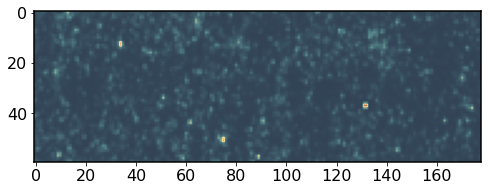

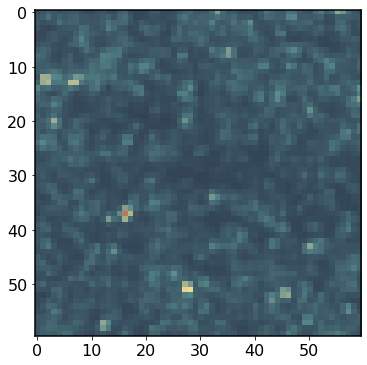

In [6]:
plt.imshow(LC_CO.obs_3d_map.preview(axes=[1,0]),cmap=cmap)
plt.show()
plt.imshow(LC_CO.obs_3d_map.preview(axes=[1,2]),cmap=cmap)
plt.show()

Now we're ready to compute some of the population statistics (non observable) and some of the main summary statistics that can actually be measured in an actual experiment

First, we start by computing the $L(M)$ relationship for the line emission and the luminosity function. This of course cannot be directly measured in a LIM survey, since individual sources are not resolved, and there is no information about the mass of host halo the signal comes from. Nonetheless, these statistics are useful to computed to characterize the signal from a given model

- $L(M)$ relationship: 2d, mean value per halo mass bin, and the median value per halo mass bin

- Luminosity function taking the total number of counts per volume per mass bin

In [7]:
#Get the halos that get into the survey and get their mass and their luminosity
Mhalos = (LC_CO.halos_in_survey_all['CO_J10']['Mhalo'].to(u.Msun)).value #transform to Msun units (from Msun/h)
logMhalo = np.log10(Mhalos)
Lhalos = LC_CO.halos_in_survey_all['CO_J10']['Lhalo']

#Get the log-binning in mass and in luminosity
logM=np.linspace(10.2, 14, 31)
logL=np.linspace(9.3,11.7, 31)

#get L(M)
meanLCO=[]
medianLCO=[]
for i in range(len(logM)-1):
    inds = (logMhalo>=logM[i])&(logMhalo<logM[i+1])&(Lhalos>0) #remove the halos that don't have any luminosity
    Lbin = Lhalos[inds]
    meanLCO.append(np.mean(Lbin).value) 
    medianLCO.append(np.median(Lbin).value)

meanLCO = np.asarray(meanLCO)*Lbin.unit
medianLCO = np.asarray(medianLCO)*Lbin.unit

#Get luminosity function
LCO_prime = Lhalos/(3.2e-11*u.Lsun)/LC_CO.line_nu0[LC_CO.target_line].value**3 #transform to L'
Nhalos, _=np.histogram(np.log10(LCO_prime[Lhalos>0]), bins=logL)
phi=Nhalos/np.diff(logL)[0]/((LC_CO.Lbox[0]*LC_CO.Lbox[1]*LC_CO.Lbox[2]).to(u.Mpc**3)) #conver to phi luminosity function



/home/jlbernal/.conda/envs/py3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jlbernal/.conda/envs/py3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


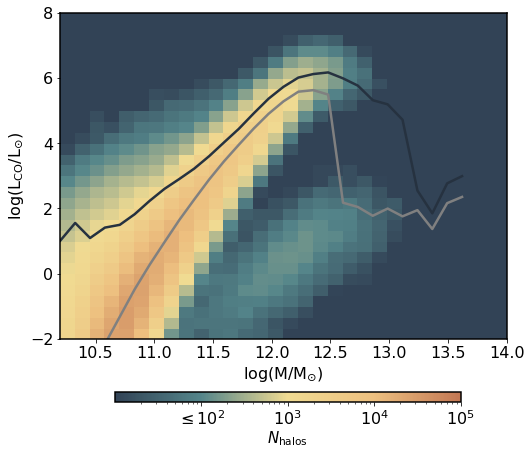

In [8]:
#make the plot for L(M)
fig, ax = plt.subplots(nrows=1, ncols=1)

im=ax.hist2d(logMhalo[Lhalos.value>0], np.log10(Lhalos.value[Lhalos.value>0]), bins=[np.linspace(10.2, 14, 31), np.linspace(-2, 8, 31)], 
            norm=matplotlib.colors.LogNorm(vmin=1e1, vmax=1e5), cmap=cmap)
ax.plot(logM[:-1], np.log10(meanLCO.value), color='#263240')
ax.plot(logM[:-1], np.log10(medianLCO.value), color='gray')
ax.set_facecolor(dark_blue)
ax.set_ylim(-2, 8)
ax.set_xlim(10.2, 14)
ax.set_xlabel(r'$\log$(M/M$_{\odot}$)')
ax.set_ylabel(r'$\log$(L$_{\rm CO}$/L$_{\odot}$)')
#ax0 = ax[0].twinx()
#ax0.plot(logM[:-1], meanLCO*(u.Lsun.to(u.erg/u.s)), alpha=0)
cbar_ax = fig.add_axes([0.22, -0.02, 0.6, 0.022])
cbar_ax.set_title(r'$N_{\rm halos}$', fontsize=15, x=0.5, y=-5)
cbar=fig.colorbar(im[3], cax=cbar_ax, orientation='horizontal')
cbar.set_ticks([1e2, 1e3, 1e4, 1e5])
cbar.set_ticklabels([r'$\leq 10^2$','$10^3$','$10^4$','$10^5$'])


In [9]:
phi

<Quantity [4.26164195e-04, 3.98415327e-04, 4.03380913e-04, 3.64824592e-04,
           3.42333404e-04, 3.04361268e-04, 3.04945455e-04, 2.76028214e-04,
           2.72523094e-04, 2.41853292e-04, 2.21114664e-04, 2.07094184e-04,
           1.72335075e-04, 1.64448555e-04, 1.44294114e-04, 1.29105260e-04,
           1.15376872e-04, 1.06029885e-04, 7.85731106e-05, 7.15628702e-05,
           5.63740161e-05, 4.29377221e-05, 3.68037618e-05, 2.51200279e-05,
           2.07386277e-05, 1.51888541e-05, 8.17861374e-06, 8.17861374e-06,
           3.21302683e-06, 3.50512017e-06] 1 / Mpc3>

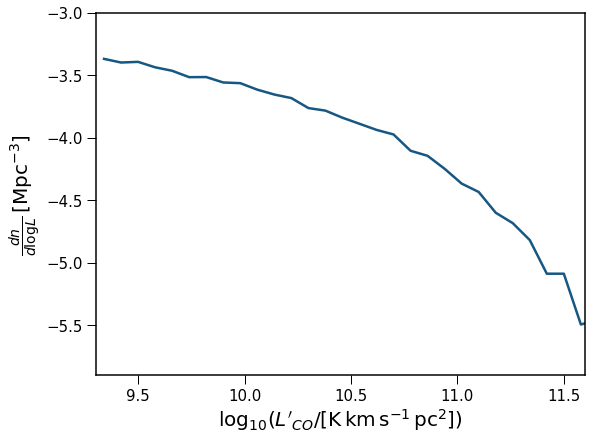

In [10]:
#make the plot for the luminsotiy function

gs = gridspec.GridSpec(1, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0)
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

ax.plot(logL[:-1]+np.diff(logL)[0]/2,np.log10(phi.value))

plt.ylim(-5.9,-3)
plt.xlim(9.3,11.6)

ax.set_ylabel(r'$\frac{dn}{d\log L}\, [{\rm Mpc}^{-3}]$',fontsize=20)
ax.set_xlabel(r"$\log_{10} (L'_{CO}/ [{\rm K\, km\, s^{-1}\, pc^2}])$",fontsize=20)
ax.tick_params(axis='both',width=1,length=9,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=15)

plt.show()

Now we go to things that can actually be measured, like the VID and the power spectrum

For the VID, let's use linear binning

In [11]:
#Temperature binning
TiCO_edge=np.linspace(-3, 35, 50+1)
TiCO=(TiCO_edge[:-1]+TiCO_edge[1:])/2.
#Get the VID 
BiCO=np.histogram(np.asarray(LC_CO.obs_3d_map).flatten(), bins=TiCO_edge)[0]


(10, 800000.0)

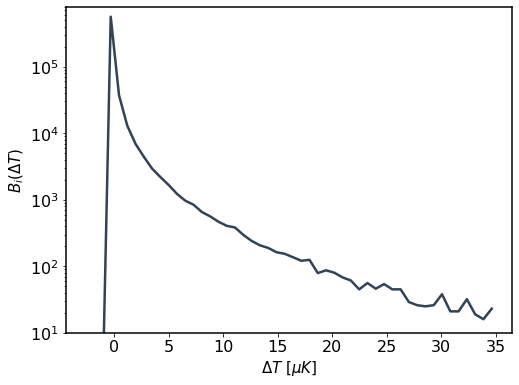

In [12]:
#plot the VID
plt.semilogy(TiCO, BiCO, color=dark_blue)
plt.xlabel(r"$\Delta T$ [$\mu K$]", fontsize = 15) #Delta T because we remove the mean
plt.ylabel("$B_{i}(\Delta T)$", fontsize=15)
plt.ylim(10,8e5)

In [13]:
#Get the k binning for the power spectrum
k = LC_CO.k_Pk_poles
#Get the power spectrum monopole
Pk0 = LC_CO.Pk_0


Note that we're using a small volume for this example to keep things running fast. This is why the power spectrum looks like this

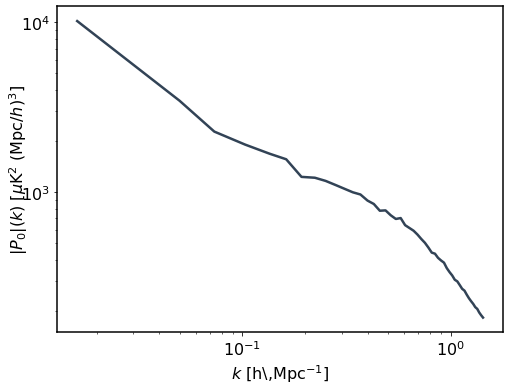

In [26]:
#Plot the Power spectrum multipoles
plt.loglog(k, Pk0, color=dark_blue)
plt.xlabel("$k$ [h\,Mpc$^{-1}]$")
plt.ylabel(r"$\vert P_0\vert (k)$ [$\mu$K$^2$ (Mpc$/h)^3$]", labelpad=-9)
plt.show()


Now we can also do cross correlations. To do that we need to run another instance of SkyLine to get the alternative map (e.g., LIM for other line, or galaxies, etc), and then cross-correlate them outside SkyLine.

Here we can see an example of how the update functionality works

In [15]:
#import the packages to deal with the external P(k) computation. For autocorrelation, this is done within SkyLine

from nbodykit.source.mesh.catalog import CompensateCICShotnoise,get_compensation
from nbodykit.algorithms import FFTPower

#to compensate for the mass asignment
compensation = get_compensation(interlaced=False,resampler='cic')



In [16]:
#let's first copy a version of the 3D map for CO LIM
CO_map = LC_CO.obs_3d_map



In [17]:
#we can update the SkyLine instance to get the number counts of ELGs (with number density = 1e-4**-3*u.Mpc**-3)
LC_CO.update(gal_type='elg',ngal=1e-4**-3*u.Mpc**-3,number_count=True,
             do_angular_smooth=False,do_spectral_smooth=False)

gal_map = LC_CO.obs_3d_map

/home/jlbernal/preLIMinary/source/survey.py:335: UserWarning: % of survey volume lost due to inner cube = 0.14142460351157948
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:444: RuntimeWarning: divide by zero encountered in log10
  inds_gal = np.where((np.log10(self.halo_catalog_all['SM_HALO'])>8)&(self.halo_catalog_all['SFR_HALO']>0))
/home/jlbernal/preLIMinary/source/survey.py:451: RuntimeWarning: invalid value encountered in true_divide
  sSFR = self.halo_catalog_all['SFR_HALO']/self.halo_catalog_all['SM_HALO']
/home/jlbernal/preLIMinary/source/survey.py:467: UserWarning: Maximum n_gal with the total number of elgs is 0.03895 1 / Mpc3, input was 999999999999.999878 1 / Mpc3, reduce it or work with all elg
  warn("Maximum n_gal with the total number of {:}s is {:.5f}, input was {:5f}, reduce it or work with all {:}".format(self.gal_type,ngal_max,self.ngal,self.gal_type))
/ho

In [18]:
#apply the compensation in Fourier space
CO_map = (CO_map.r2c().apply(compensation[0][1], kind=compensation[0][2]))
gal_map = (gal_map.r2c().apply(compensation[0][1], kind=compensation[0][2]))


In [22]:
#compute the power spectra in 2d (k,mu)
kmin=0*u.Mpc**-1
kmax=1*u.Mpc**-1
dk=0.02*u.Mpc**-1

galxCO=FFTPower(CO_map, '2d', second=gal_map, Nmu=30, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_CO.Mpch**-1).value, kmin=kmin.to(LC_CO.Mpch**-1).value, 
                kmax=kmax.to(LC_CO.Mpch**-1).value, BoxSize=np.array(LC_CO.Lbox.value, dtype=np.float32))


In [23]:
# Get the power spectrum monopole with the correct units
k, xPk0 = (galxCO.poles['k']*u.Mpc**-1).to(u.Mpc**-1),(galxCO.poles['power_0'].real*u.Mpc**3).to(u.Mpc**3)*LC_CO.unit


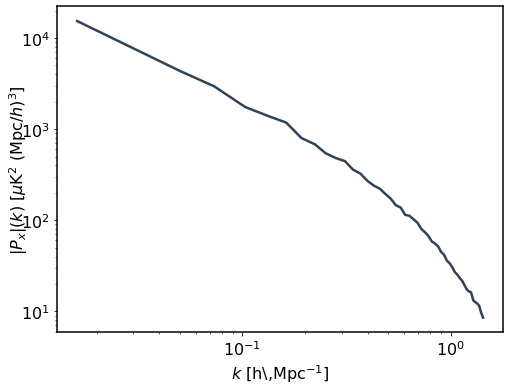

In [24]:
#Plot the Power spectrum multipoles
plt.loglog(k, xPk0, color=dark_blue)
plt.xlabel("$k$ [h\,Mpc$^{-1}]$")
plt.ylabel(r"$\vert P_x\vert (k)$ [$\mu$K$^2$ (Mpc$/h)^3$]", labelpad=-9)
plt.show()
